> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 


This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue , popularity
id, imdb_id , budget, title,cast,homepage,director,tagline,keywords,overview,runtime,genres, production companies , release date,revenue adjusted for inflation and budget adjusted for inflation
most significant columns would include budget revenue runtime popularity and user ratings



### What qualities make a movie popular? what qualities make a movie profitable?
### what are the top ten profitable movies? what are the top ten profitable years for movie making?
### is the movie making industry thriving or dying ? 

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
df = pd.read_csv('tmdb-movies.csv')


In [47]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

let's take a look at how the data looks

In [93]:
df.head()

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_average,release_year,profit
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,6/9/15,6.5,2015,1363528810
1,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,5/13/15,7.1,2015,228436354
2,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,3/18/15,6.3,2015,185238201
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,7.5,2015,1868178225
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,4/1/15,7.3,2015,1316249360


some columns like genres and cast have multiple values seperated by |
may need to divide them if we wish to analyze indiviual actor or genre

In [3]:
df.describe()


,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [4]:
df.shape

(10866, 21)

In [5]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

there seems to be some columns that we will not need, budget adj and revenue adj is not needed in the presence of budget  and revenue .
homepage, tagline, production companies,overview , id , imdb_id ,vote_count and keywords will not be relevant in our analysis
looking at the statistical analysis of the data we find that Q1 Q2 Q3 of budget and revenue are zeroes and upon investigation
some columns have missing values although not in null form but rather as zeros


and now to check exactly how many zero values are there

In [7]:
df['revenue'].value_counts()


0            6016
12000000       10
10000000        8
11000000        7
6000000         6
5000000         6
2000000         6
13000000        5
20000000        5
14000000        5
30000000        5
7000000         4
4300000         4
4000000         4
1000000         4
50000000        4
25000000        4
60000000        3
6700000         3
11              3
16000000        3
15              3
29000000        3
21000000        3
100000000       3
102000000       3
3               3
16              3
2500000         3
70000000        3
             ... 
42721196        1
79958599        1
40084041        1
442965          1
50752337        1
30857814        1
1400000         1
7027290         1
303788635       1
10300000        1
45916769        1
26049082        1
211989043       1
41009669        1
346079773       1
4729352         1
23159305        1
272742922       1
525             1
2626800         1
39946780        1
3117985         1
22270           1
65884703        1
4500000   

In [8]:
df['budget'].value_counts()

0            5696
20000000      190
15000000      183
25000000      178
10000000      176
30000000      165
5000000       141
40000000      134
35000000      128
12000000      120
50000000      112
6000000       109
8000000       102
3000000       101
60000000       99
7000000        92
4000000        84
2000000        81
18000000       74
1000000        73
70000000       66
11000000       65
45000000       64
80000000       62
13000000       59
17000000       59
14000000       56
22000000       54
3500000        52
75000000       51
             ... 
9100000         1
34200000        1
818418          1
14200000        1
8400000         1
22997992        1
7000            1
220000          1
23600000        1
1645000         1
82500000        1
27220000        1
5112027         1
75              1
1052753         1
225000          1
115             1
12000           1
163000000       1
2240000         1
786675          1
4250000         1
207000000       1
61733           1
19885552  

there seems to be alot of entries with no budget, filling them with the mean will likely hurt our analysis so i think it's best to drop them all 

let's now check if the data has any duplicate rows

In [10]:
print(df.duplicated().sum())


1


there also seems to be one duplicated row


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

### we will be removing the irrelevant columns of the data


In [11]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
# we will be removing the irrelevant columns of the data

df.drop(['id','imdb_id','homepage','tagline','keywords','overview','production_companies','vote_count','budget_adj','revenue_adj'], axis = 1, inplace = True)
df.head()

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_average,release_year
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,6/9/15,6.5,2015
1,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,5/13/15,7.1,2015
2,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,3/18/15,6.3,2015
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,7.5,2015
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,4/1/15,7.3,2015


to check how many columns we have now

In [94]:
df.shape

(3854, 12)

now to drop all the rows that have either zero budget or revenue in its cell

In [15]:
df = df[df.revenue != 0]

In [16]:
df = df[df.budget != 0]

and now check the rows we have after the data cleaning

In [17]:
df.shape

(3855, 11)

In [18]:
df.describe()

,popularity,budget,revenue,runtime,vote_average,release_year
count,3855.000000,3.855000e+03,3.855000e+03,3855.000000,3855.00000,3855.000000
mean,1.191400,3.720183e+07,1.076589e+08,109.215824,6.16786,2001.263294
std,1.475002,4.220291e+07,1.765248e+08,19.922166,0.79504,11.281989
min,0.001117,1.000000e+00,2.000000e+00,15.000000,2.20000,1960.000000
25%,0.462448,1.000000e+07,1.357645e+07,95.000000,5.70000,1995.000000
50%,0.797298,2.400000e+07,4.479322e+07,106.000000,6.20000,2004.000000
75%,1.368245,5.000000e+07,1.241530e+08,119.000000,6.70000,2010.000000
max,32.985763,4.250000e+08,2.781506e+09,338.000000,8.40000,2015.000000


let's also drop the one duplicate in our data

In [19]:
df.shape

(3855, 11)

In [20]:
df.drop_duplicates(inplace=True)


In [21]:
df.shape

(3854, 11)

successfully dropped the duplicate

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### What are the  Most Profitable Movies of all time ?




we have to create a profit column and add it to the data, profit is obtained by
substracting the revenue from the budget
two values that this database have

In [22]:
df['profit'] = df['revenue'] - df['budget']

In [23]:
df.head()

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_average,release_year,profit
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,6/9/15,6.5,2015,1363528810
1,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,5/13/15,7.1,2015,228436354
2,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,3/18/15,6.3,2015,185238201
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,7.5,2015,1868178225
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,4/1/15,7.3,2015,1316249360


to see the most profitable movies let's sort the data by profit

In [96]:
df_profit_sorted = df.sort_values('profit',ascending=False)

now get only the top ten most profitable movies

In [25]:
top_ten_profit = df_profit_sorted.head(10)

In [26]:
top_ten_profit

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_average,release_year,profit
1386,9.432768,237000000,2781505847,Avatar,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,James Cameron,162,Action|Adventure|Fantasy|Science Fiction,12/10/09,7.1,2009,2544505847
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,7.5,2015,1868178225
5231,4.355219,200000000,1845034188,Titanic,Kate Winslet|Leonardo DiCaprio|Frances Fisher|...,James Cameron,194,Drama|Romance|Thriller,11/18/97,7.3,1997,1645034188
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,6/9/15,6.5,2015,1363528810
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,4/1/15,7.3,2015,1316249360
4361,7.637767,220000000,1519557910,The Avengers,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,Joss Whedon,143,Science Fiction|Action|Adventure,4/25/12,7.3,2012,1299557910
3374,5.711315,125000000,1327817822,Harry Potter and the Deathly Hallows: Part 2,Daniel Radcliffe|Rupert Grint|Emma Watson|Alan...,David Yates,130,Adventure|Family|Fantasy,7/7/11,7.7,2011,1202817822
14,5.944927,280000000,1405035767,Avengers: Age of Ultron,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,Joss Whedon,141,Action|Adventure|Science Fiction,4/22/15,7.4,2015,1125035767
5422,6.112766,150000000,1274219009,Frozen,Kristen Bell|Idina Menzel|Jonathan Groff|Josh ...,Chris Buck|Jennifer Lee,102,Animation|Adventure|Family,11/27/13,7.5,2013,1124219009
8094,1.136610,22000000,1106279658,The Net,Sandra Bullock|Jeremy Northam|Dennis Miller|We...,Irwin Winkler,114,Crime|Drama|Mystery|Thriller|Action,7/28/95,5.6,1995,1084279658


<Container object of 10 artists>

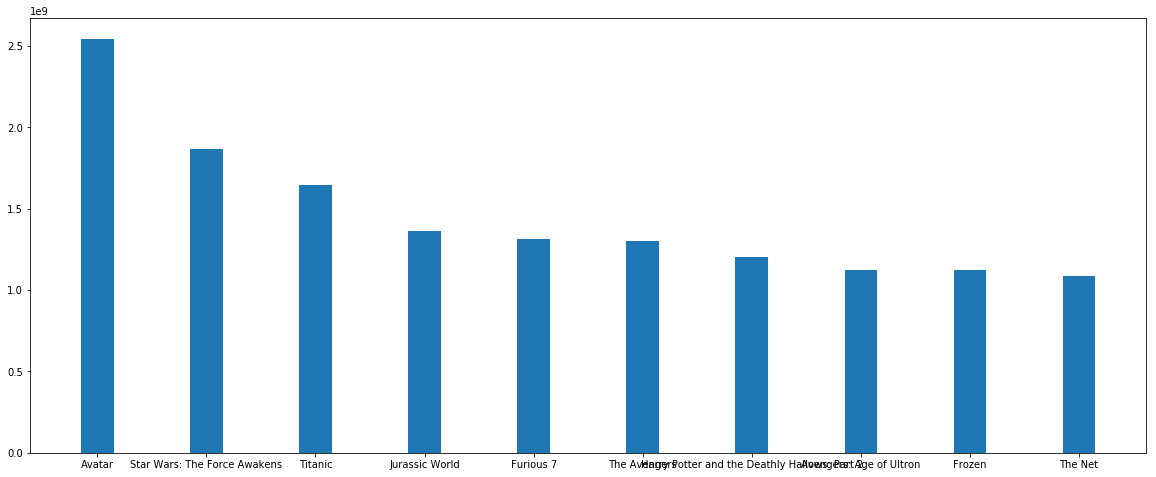

In [27]:
plt.figure(figsize=(20, 8)) 
plt.bar([1,2,3,4,5,6,7,8,9,10], top_ten_profit['profit'],tick_label=top_ten_profit['original_title'], width=.3)


In [28]:
top_ten_profit['original_title']

1386                                          Avatar
3                       Star Wars: The Force Awakens
5231                                         Titanic
0                                     Jurassic World
4                                          Furious 7
4361                                    The Avengers
3374    Harry Potter and the Deathly Hallows: Part 2
14                           Avengers: Age of Ultron
5422                                          Frozen
8094                                         The Net
Name: original_title, dtype: object

from the above query we can see that the top 10 most profitable movies of all time are
1-Avatar 2-Star Wars: The Force Awakens 3-Titanic 4-Jurassic World 5-Furious 7 6-The Avengers 7-Harry Potter and the Deathly Hallows: Part 2 
8-Avengers: Age of Ultron 9-Frozen
10-The Net

###  What kinds of properties are associated with movies that have high profit?

inorder to examine what qualties does highly profitable movies share we must first create a dataframe that contains only the 
most profitable movies on the the list

we will do that by taking anything above the third quartert Q3 of the data





In [38]:
Q3 = df.describe().profit[6]

In [39]:
Q3

81703308.0

In [35]:
profitable_movies = df.query("profit > {}".format(Q3))

check on our new data

In [42]:
profitable_movies.shape

(964, 12)

In [43]:
profitable_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 10760
Data columns (total 12 columns):
popularity        964 non-null float64
budget            964 non-null int64
revenue           964 non-null int64
original_title    964 non-null object
cast              964 non-null object
director          964 non-null object
runtime           964 non-null int64
genres            964 non-null object
release_date      964 non-null object
vote_average      964 non-null float64
release_year      964 non-null int64
profit            964 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 97.9+ KB


### what is the average runtime for the most profitable movies ? 

this is a function to calculate the mean value for any certain column 

In [109]:
def avg_prof(column):
    return profitable_movies[column].mean()

In [45]:
profitable_movies.describe()

,popularity,budget,revenue,runtime,vote_average,release_year,profit
count,964.000000,9.640000e+02,9.640000e+02,964.000000,964.000000,964.000000,9.640000e+02
mean,2.291243,6.966615e+07,3.147646e+08,115.214730,6.447407,2002.704357,2.450985e+08
std,2.329738,5.669029e+07,2.508670e+08,21.223396,0.700040,10.373339,2.177251e+08
min,0.131526,1.130000e+02,8.627333e+07,72.000000,4.400000,1961.000000,8.172336e+07
25%,1.097410,2.675000e+07,1.595448e+08,99.000000,6.000000,1997.000000,1.131544e+08
50%,1.695317,5.400000e+07,2.314304e+08,113.000000,6.400000,2005.000000,1.655408e+08
75%,2.691073,1.000000e+08,3.682613e+08,128.000000,7.000000,2011.000000,2.871736e+08
max,32.985763,3.800000e+08,2.781506e+09,201.000000,8.300000,2015.000000,2.544506e+09


In [110]:
avg_prof('runtime')

115.21473029045643

the average runtime for the most profitable movies is 115.2 minutes

### what is the average budget for the most profitable movies ? 

In [111]:
avg_prof('budget')

69666148.457468882

the average budget for the most profitable movies is 69666148.45 usd


### what is the average vote for the most profitable movies ? 

In [112]:
avg_prof('vote_average')

6.4474066390041482

the average vote for the most profitable movies is 6.4

###  What kinds of properties are associated with movies that are highly  popular ?

inorder to examine what qualties does highly popular movies share we must first create a dataframe that contains only the 
most popular movies on the the list

we will do that by taking anything above the third quartert Q3 of the data


In [49]:
df.describe()

,popularity,budget,revenue,runtime,vote_average,release_year,profit
count,3854.000000,3.854000e+03,3.854000e+03,3854.000000,3854.000000,3854.000000,3.854000e+03
mean,1.191554,3.720370e+07,1.076866e+08,109.220291,6.168163,2001.261028,7.048292e+07
std,1.475162,4.220822e+07,1.765393e+08,19.922820,0.794920,11.282575,1.506195e+08
min,0.001117,1.000000e+00,2.000000e+00,15.000000,2.200000,1960.000000,-4.139124e+08
25%,0.462368,1.000000e+07,1.360003e+07,95.000000,5.700000,1995.000000,-1.321535e+06
50%,0.797511,2.400000e+07,4.480000e+07,106.000000,6.200000,2004.000000,2.002019e+07
75%,1.368324,5.000000e+07,1.242125e+08,119.000000,6.700000,2010.000000,8.170331e+07
max,32.985763,4.250000e+08,2.781506e+09,338.000000,8.400000,2015.000000,2.544506e+09


In [50]:
Q3pop = df.describe().popularity[6]
Q3pop

1.3683240000000001

In [51]:
pop_movies = df.query("popularity > {}".format(Q3pop))
pop_movies.shape

(964, 12)

In [53]:
pop_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 10756
Data columns (total 12 columns):
popularity        964 non-null float64
budget            964 non-null int64
revenue           964 non-null int64
original_title    964 non-null object
cast              964 non-null object
director          964 non-null object
runtime           964 non-null int64
genres            964 non-null object
release_date      964 non-null object
vote_average      964 non-null float64
release_year      964 non-null int64
profit            964 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 97.9+ KB


In [54]:
pop_movies.describe()

,popularity,budget,revenue,runtime,vote_average,release_year,profit
count,964.000000,9.640000e+02,9.640000e+02,964.000000,964.000000,964.000000,9.640000e+02
mean,2.795850,6.751690e+07,2.629789e+08,115.142116,6.595332,2004.417012,1.954620e+08
std,2.220460,5.842812e+07,2.698093e+08,21.020129,0.736152,11.012801,2.354061e+08
min,1.368403,4.000000e+05,2.500000e+02,63.000000,3.800000,1960.000000,-9.999975e+07
25%,1.660657,2.300000e+07,8.967653e+07,100.000000,6.100000,2001.000000,4.788506e+07
50%,2.148295,5.000000e+07,1.786231e+08,112.000000,6.600000,2008.000000,1.218212e+08
75%,3.073780,1.000000e+08,3.517161e+08,127.000000,7.200000,2013.000000,2.573828e+08
max,32.985763,3.800000e+08,2.781506e+09,201.000000,8.400000,2015.000000,2.544506e+09


### what is the average runtime for the most popular movies ? 

this is a function to calculate the mean value for any certain column 

In [114]:
def avg_pop(column):
    return pop_movies[column].mean()

In [55]:
pop_movies.runtime.mean()

115.14211618257261

the average runtime of the most popular movies is 115.14 minutes

### what is the average budget for the most popular movies ? 

In [117]:
avg_pop('budget')

67516901.072614104

the average budget of the most popular movies is 67516901.07 usd 

### what is the average vote for the most popular movies ? 

In [119]:
avg_pop('vote_average')

6.5953319502074699

the average vote of the most popular movies is 6.595 

### now let's do some comparisons between our findings in both datasets

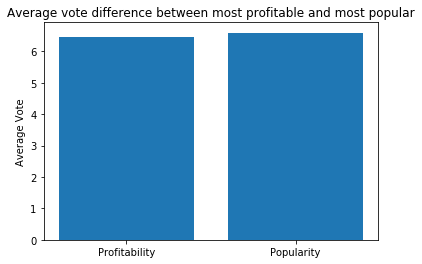

In [120]:
plt.bar([1,2], [avg_prof('vote_average'),avg_pop('vote_average')],tick_label=['Profitability','Popularity' ])
plt.title('Average vote difference between most profitable and most popular')
plt.ylabel('Average Vote');

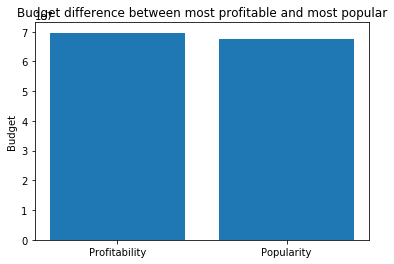

In [121]:
plt.bar([1,2], [avg_prof('budget'),avg_pop('budget')],tick_label=['Profitability','Popularity' ])
plt.title('Budget difference between most profitable and most popular')
plt.ylabel('Budget');

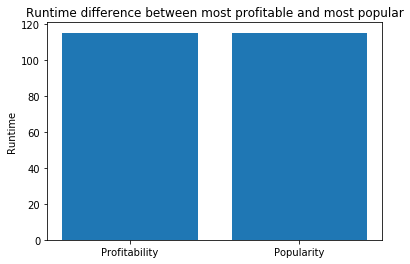

In [123]:
plt.bar([1,2], [avg_prof('runtime'),avg_pop('runtime')],tick_label=['Profitability','Popularity' ])
plt.title('Runtime difference between most profitable and most popular')
plt.ylabel('Runtime');

### what years saw the highest profit for movies ?

to find the most profitable years we will group the dataset by year and add up all movies profit for that year

In [98]:
years_prof_ord = df.groupby('release_year')['profit'].sum().sort_values(ascending=False)

In [99]:
topten_year_prof = years_prof_ord.head(10)

In [100]:
topten_year_prof

release_year
2015    19032145273
2014    16676201357
2012    16596845507
2013    15782743325
2011    14966694704
2009    14069305071
2010    13341222037
2008    11843373159
2007    11686103667
2004     9822506642
Name: profit, dtype: int64

In [101]:
prof_year_order=['2015','2014','2012','2013','2011','2009','2010','2008','2007','2004']

<Container object of 10 artists>

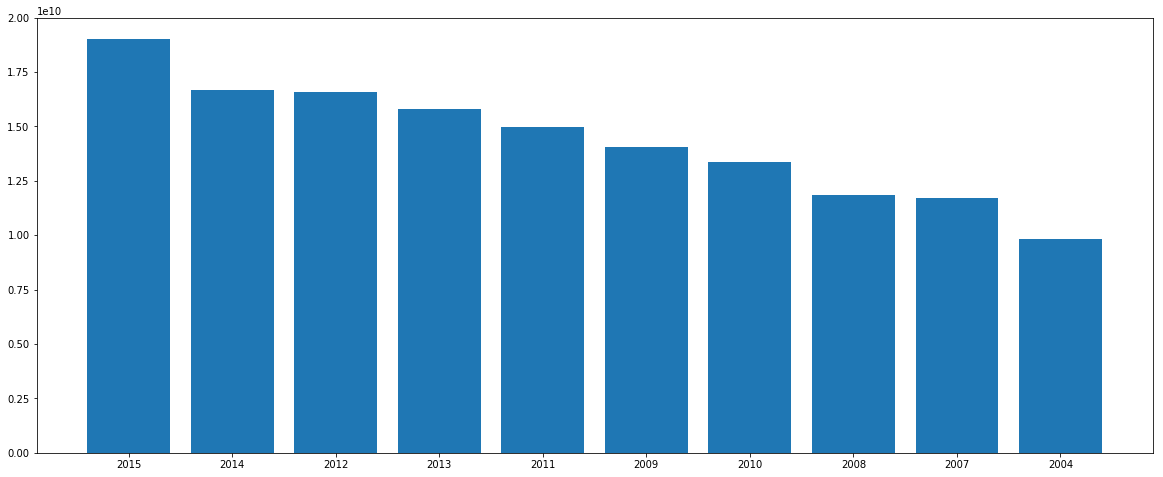

In [102]:
plt.figure(figsize=(20, 8)) 
plt.bar([1,2,3,4,5,6,7,8,9,10], topten_year_prof,tick_label=prof_year_order)


### is the movie making industry thriving or dying ? 

In [103]:
years_prof = df.groupby('release_year')['profit'].sum()

In [104]:
years_prof

release_year
1960      108198052
1961      299083188
1962      166879846
1963      115411882
1964      294678387
1965      399281854
1966       52468689
1967      636334637
1968      168271762
1969      206862989
1970      454070023
1971      336284710
1972      457235917
1973     1057686099
1974      650582027
1975      808207270
1976      629426536
1977     1743308485
1978     1005100089
1979      950330150
1980     1002065664
1981     1320251458
1982     1811756359
1983     1505073842
1984     1833438131
1985     1666899046
1986     1665354869
1987     2148546726
1988     2313076703
1989     3603940908
1990     3454904971
1991     3048121485
1992     3873046070
1993     4575828325
1994     4704384415
1995     5608098320
1996     4736626727
1997     6380241248
1998     5274145395
1999     6433209130
2000     6110774823
2001     8022044875
2002     9004589344
2003     9202155213
2004     9822506642
2005     9259452998
2006     8726299999
2007    11686103667
2008    11843373159
2009   

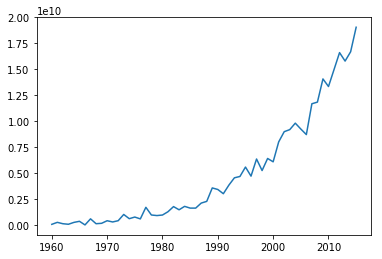

In [105]:
plt.plot(years_prof)

movie making seems to only be getting more profitable as time goes by

<a id='conclusions'></a>
## Conclusions

What qualities make a movie popular? what qualities make a movie profitable?
for a movie to be popular it should have a
    runtime of 115.14 minutes
    budget of 67516901.07 usd
for a movie to be profitable it should have a 
    runtime of 115.2 minutes
    budget of 69666148.45 usd
popular movies are higher rated than profitable ones
popular movies vote average : 6.59
profitable movies vote average: 6.44

top 10 most profitable movies of all time are
1-Avatar 2-Star Wars: The Force Awakens 3-Titanic 4-Jurassic World 5-Furious 7 6-The Avengers 7-Harry Potter and the Deathly Hallows: Part 2 8-Avengers: Age of Ultron 9-Frozen 10-The Net

what are the top ten profitable years for movie making?
1-2015 2-2014 3-2012 4-2013 5-2011 6-2009 7-2010 8-2008 9-2007 10-2004

is the movie making industry thriving or dying ? 
movie making seems to only be getting more profitable as time goes by

the limitations were many budget and revenue cells were filled in as zero , the data is not up to date



## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])